<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [ ]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20214537" #@param {type:"string"}
Student_full_name = "Tom Keane" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [ ]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import libraries
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.utils import shuffle

import scipy.optimize as optimize
from scipy.special import erf
from scipy.io import loadmat

import pandas as pd
import numpy as np
import random

import seaborn as sns
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.color import rgb2gray
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
import pymc3 as pm
from IPython.display import HTML
import pickle
import theano as tt
import cv2
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [12, 8] 

In [ ]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path, copy the path from your Drive
Path = "/content/drive/MyDrive/UL Masters/ET5003/Week-1/"

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [ ]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

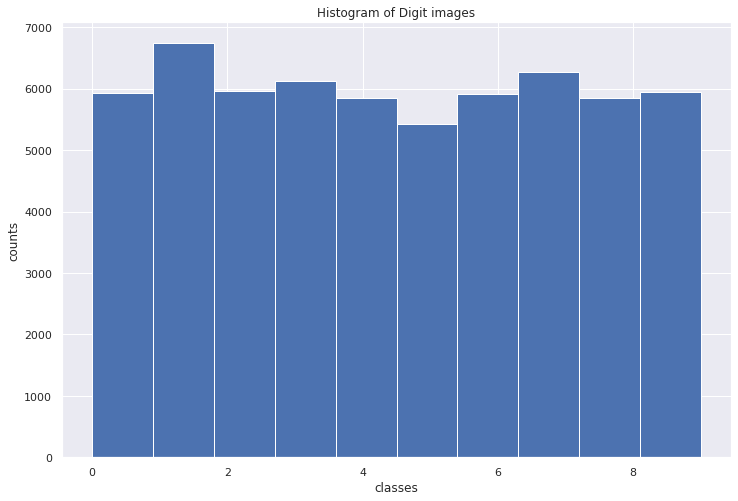

In [ ]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [ ]:
# We select the number of Classes we want:
n_classes = 3
classes = np.sort(np.random.choice(10, n_classes, False))
# print classes selected
classes

array([0, 4, 7])

In [ ]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 3000

inputs = []
labels = []
# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

New Classes Distribution

In [ ]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Original')

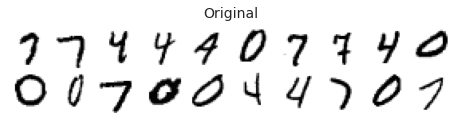

In [ ]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,16))

n_label_indices = 20
# Selecting a few label indices from each of the 3 classes to show:
label_indices = np.random.choice(len(X_train),n_label_indices,replace=False)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=n_label_indices//2)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [ ]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

# print shape of your validation and training set
print("validation set shapes\n  X: ",X_val.shape, "\n  y: ",y_val.shape)
print("traininng set shapes\n  X: ",X_train.shape, "\n  y: ",y_train.shape)

validation set shapes
  X:  (1800, 784) 
  y:  (1800,)
traininng set shapes
  X:  (7200, 784) 
  y:  (7200,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

#### [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) SKLEARN Docs

**lbfgs** - Stands for limited-memory BFGS. This solver only calculates an approximation to the Hessian based on the gradient which makes it computationally more effective. On the other hand it’s memory usage is limited compared to regular bfgs which causes it to discard earlier gradients and accumulate only fresh gradients as allowed by the memory restriction.

In [ ]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)
prob_classmax = np.max(y_pred_logi_prob,axis=1)


# Computing the Accuracy:
LR_initial_accuracy_score          = accuracy_score(y_pred_log, y_val)
LR_initial_misclassification_count = len(prob_classmax[y_pred_log!=y_val])
print(f'accuracy: {accuracy_score(y_pred_log, y_val)}')
print(f'misclassifications: {len(prob_classmax[y_pred_log!=y_val])}')

accuracy: 0.9855555555555555
misclassifications: 26


### General Recipe ML Results

We have the probability of each classification with respect to each image. Let's see how the often logistic regressor is at least 95% sure about it's classification.

(1800, 3)
98.7778


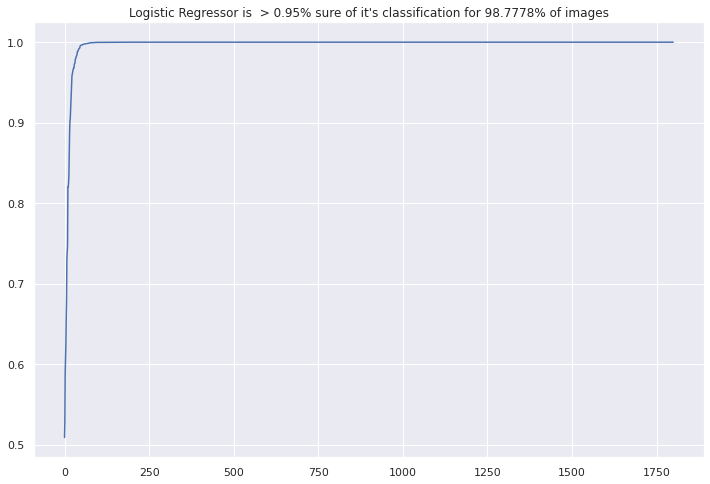

In [ ]:
# Maybe taking the maximum probability 
# in any of the classes for each observation
print(np.shape(y_pred_logi_prob))
maximum_prob = y_pred_logi_prob.max(axis=1)

thresh = 0.95
max_prob_meets_thresh_perc = round(
    sum(maximum_prob > thresh)*100/len(maximum_prob), 4
    )
print(max_prob_meets_thresh_perc)
ax = plt.axes()
sns.lineplot(range(len(maximum_prob)), np.sort(maximum_prob), ax = ax)

ax.set_title(f'Logistic Regressor is  > {thresh}% sure of it\'s classification for {max_prob_meets_thresh_perc}% of images')
plt.show()

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [ ]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [ ]:
# Model training
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 11,609


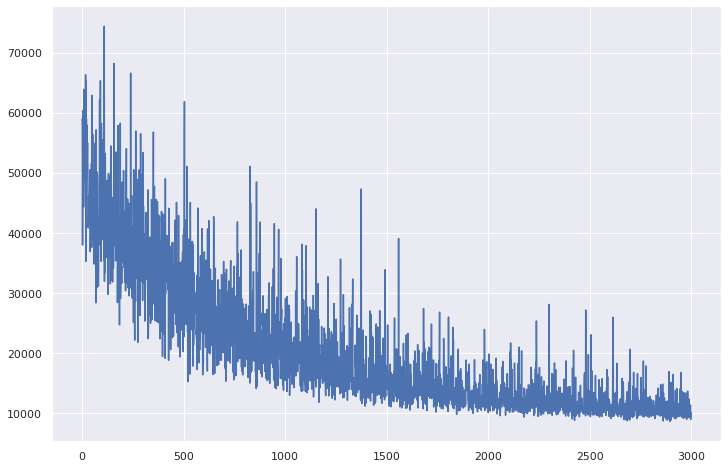

In [ ]:
plt.plot(approx.hist)

In [ ]:
dd = 300
posterior = approx.sample(draws=dd)
print(posterior)

<MultiTrace: 1 chains, 300 iterations, 2 variables>


test image #92
posterior sample #100
true class= 7.0
classes: [0 4 7]
estimated prob= [0.00005561 0.00008395 0.99986045]


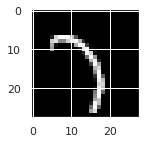

In [ ]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
# i = 10 
i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28, 28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [ ]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [ ]:
# recall the classes we are using
print(classes)

# prediction array (using classes)
nn = 10 # just an example
print(np.array(classes)[y_pred_Bayesian[0:nn]]
)
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

[0 4 7]
[4 0 0 7 0 4 0 7 0 0]
Accuracy= 0.9655555555555555



Selecting different instances¶


In [ ]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [ ]:
# prediction array
mm = 10

#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
print(f"sorted prediction array:\n {y_predB[difficult[0:mm],:]}\n")

#probability of general-recipe logistic regression in wrong instances
print(f"probability of general-recipe logistic regression in wrong instances:\n{prob_classmax[y_pred_log != y_val]}")

## Difficult & easy instances
easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

In [ ]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28, 28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

In [ ]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28, 28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

#Tasks 3 & 4

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.


In [ ]:
# removing 'non easy to classify' classes - those with standard deviation above 0.25
thresh_SD = 0.2
X_val_easies = X_val[y_predB[:,2] < thresh_SD]
y_val_easies = y_val[y_predB[:,2] < thresh_SD]

print(f"{len(X_val) - len(X_val_easies)}, ( {(len(X_val) - len(X_val_easies))*100/len(X_val)}% ) instances removed.")
print(f"Now using {len(X_val_easies)} instances\n")

# model
# model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_easy_pred_log = model_log.predict(X_val_easies)
y_easy_pred_logi_prob = model_log.predict_proba(X_val_easies)
easy_prob_classmax = np.max(y_easy_pred_logi_prob,axis=1)


# Computing the Accuracy:
print(f"initial LR results:\n  Accuracy: {LR_initial_accuracy_score}\n  misclassifications: {LR_initial_misclassification_count}")
          
print(f"results from tests with recognised easier samples\n  accuracy: {accuracy_score(y_easy_pred_log, y_val_easies)}\n  misclassifications: {len(easy_prob_classmax[y_easy_pred_log!=y_val_easies])}")

## Summary

In this Assignment, 3  of the ten digitts from 0 - 9 were randomly selected and used to analyse the classification performance of a General Recipe Logistic Regression algorithm, and contrast it with a Bayesian approach, using a Probabilistic Multinomial Logistic Regression algorithm.

The initial ***Logistic Regressor*** performed well, with 0.985 accuracy. However, this approach did not give us any context as to which instances are easy or hard to classify, and the algorithm will give a wrong answer in uncertain cases, rather than declining to provide a classification, which in certain real life cases may be preferable.

***The Bayesian classifier*** was then trained on the same data set, and when tested had a similar accuracy of Accuracy= 0.965. This slight reduction in accuracy may have been due to the model declining to classify edge cases, where multiple reasonable classifications for an instance may have been made.

The results from the Bayesian analysis, allowed for the retesting of the initial Logistic Regresssion Model. This performed much better, when retested with the 'easier images' which were identified by the Bayesian Probabilistic Multinomial Logistic Regression.

